In [12]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.models as models
import torchvision.datasets as datasets
import split_folders
import matplotlib.pyplot as plt
import os

In [13]:
class CNNNet(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3,padding = 1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size = 3,padding = 2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(8)
        self.fc1 =  nn.Linear(25992,1024)
        self.act3 = nn.ReLU()
        self.out = nn.Linear(1024,102)
    
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.bn1(out)
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.bn2(out)
        out = out.view(out.size(0),-1)
        out = self.act3(self.fc1(out))
        out = self.out(out)
        return out


I chose these specific layers after experimenting a LOT with Batch Norms and deeper Networks. 
It turns out that Batchnorm layers significantly affect the performance of the model, along with the slight regularization 
effect they provide.

In [14]:
transformations = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()
                                      ,transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])])


In [15]:
train_set = datasets.ImageFolder("C:\\Users\\heman\\Desktop\\fbird_trnval\\train", transform = transformations)
val_set = datasets.ImageFolder("C:\\Users\\heman\\Desktop\\fbird_trnval\\val",transform = transformations)

In [16]:
train_loader = DataLoader(train_set,batch_size = 200,shuffle = True)
val_loader = DataLoader(train_set,batch_size = 100,shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


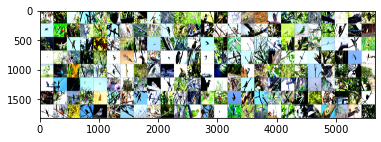

tensor([63, 37, 65, 62, 10, 41, 57, 48, 81,  2, 44, 81, 60, 77, 69, 57, 81, 10,
        77, 63, 80, 16, 65, 56, 12, 39, 64, 11, 55, 29, 30, 78, 46, 81, 65, 73,
        35, 66, 46, 76, 48, 66, 40, 79, 39, 85, 56, 56, 40, 81, 66, 33, 45, 52,
        13, 31, 74, 54, 24, 54, 10, 52, 26, 53, 31, 37, 32, 65, 55, 54, 81, 39,
        57, 32, 78, 21, 65, 27, 33, 52, 36, 18, 31, 14, 21, 46, 41, 24, 60, 31,
        39,  3, 55, 46, 75, 48, 49, 76, 28, 39, 78, 41, 76, 11, 85, 61, 46, 17,
        45, 36, 44, 13, 34,  5, 77, 57, 77, 37, 44, 27, 50, 15, 53, 77, 78, 43,
        40, 11, 58, 21, 81, 31, 82, 20,  8, 46, 33, 55, 39,  5, 30, 77, 48, 31,
        36, 58,  2, 16, 15, 47, 64, 77, 40, 13,  2, 43, 77, 38, 31, 57, 82, 29,
         6, 29, 24, 46, 65,  1, 44, 35, 77, 32, 41, 32, 61, 79, 33, 45, 62, 20,
        33, 50,  3, 74, 38, 56, 61,  8, 28, 41, 69, 75, 38, 54, 40,  0, 63, 62,
        63, 44])


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images,nrow = 25))
# print labels
print(labels)

The above is a snapshot of the data, as the data is too large to be uploaded to this repository.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = CNNNet()

In [20]:
model = model.to(device)
tr_losshist = []
tr_acchist = []
val_acchist = []
n_epoch = 5
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(n_epoch):
    model.train()
    for i, (img,lbl) in enumerate(train_loader):
        img,lbl = img.to(device),lbl.to(device)
        
        out = model(img)
        loss = crit(out,lbl)
        tr_losshist.append(loss.item())
        loss.backward()#---------------- calculating gradients
        optimizer.step()#--------------- updating the weight values
        optimizer.zero_grad()#---------- zeroing the gradients
        _,tr_pred = torch.max(out.data,1)
        crrct = (tr_pred==lbl).sum().item()
        total = lbl.size(0)
        tr_acchist.append(crrct/total*100)
        
        if((i+1)%100 == 0):
            print('Epoch [{}/{}],  Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, n_epoch, loss.item(),
                          (crrct / total) * 100))
            
    model.eval()
    with torch.no_grad():
        val_totcrrct = 0
        val_total = 0
        for i,(img,lbl) in enumerate(val_loader):
            img,lbl = img.to(device),lbl.to(device)
            
            out = model(img)
            
            _,val_pred = torch.max(out.data,1)
    
            crrct = (val_pred==lbl).sum().item()
            total = lbl.size(0)
            val_acchist.append(crrct/total*100)
            val_totcrrct+=crrct
            val_total+=total
            if((i+1)%100 == 0):
                print("Val accuracy of model :{:.3f} %".format((val_totcrrct/val_total)*100))
    if(epoch == 4):
        path = "C:\\Users\\heman"
        torch.save(model.state_dict(),os.path.join(path,"custcnn.pth"))
        

KeyboardInterrupt: 

In [8]:
model = CNNNet()
model.load_state_dict(torch.load(os.path.join(path,"custcnn.pth")))
model.eval()

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=25992, out_features=1024, bias=True)
  (act3): ReLU()
  (out): Linear(in_features=1024, out_features=102, bias=True)
)

In [10]:
model = model.to(device)
tr_losshist = []
tr_acchist = []
val_acchist = []
n_epoch = 5
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
crit = nn.CrossEntropyLoss()
for epoch in range(n_epoch):
    model.eval()
    with torch.no_grad():
        val_totcrrct = 0
        val_total = 0
        for (img,lbl) in val_loader:
            img,lbl = img.to(device),lbl.to(device)
            
            out = model(img)
            
            _,val_pred = torch.max(out.data,1)
    
            crrct = (val_pred==lbl).sum().item()
            total = lbl.size(0)
            val_acchist.append(crrct/total*100)
            val_totcrrct+=crrct
            val_total+=total
        print("Val accuracy of model :{:.3f} %".format((val_totcrrct/val_total)*100))
    

Val accuracy of model :0.731 %
Val accuracy of model :0.731 %


KeyboardInterrupt: 

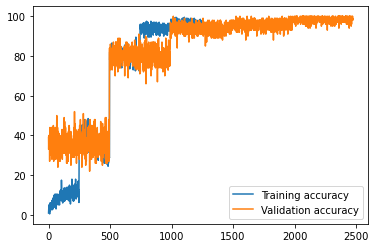

In [14]:
plt.plot(tr_acchist,label = "Training accuracy")
plt.plot(val_acchist,label = "Validation accuracy")
plt.legend()
plt.show()